# [Hands-On] Sound to Image: Exploring Audio Visualization Techniques

- Author : Sangkeun Jung (hugmanskj@gmail.com)

> Educational Purpose


## Introduction

Sound processing and classification have become increasingly important in various fields, from speech recognition to music analysis. One of the key insights in modern audio processing is that treating **sound as an image** can provide significant advantages.

This approach allows us to leverage powerful image processing and computer vision techniques for sound analysis.

In this notebook, we'll explore different methods of visualizing sound and understand how these visualizations can be used in sound classification tasks.

## Visualizing Sound
There are several ways to display sound, each offering unique insights into the audio signal:

* Waveform
* Spectrogram
* Mel-Frequency Cepstral Coefficients (MFCC)
* Mel Spectrogram

Let's examine each of these methods.

In [1]:
# Install required packages
!pip install -qq librosa==0.10.2 matplotlib==3.10.0

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torch
import torchaudio

#### Sample Wav file download

In [3]:
!wget "https://www.dropbox.com/scl/fi/674urvm1ufrcunffnkg23/648531__lazymonk__orchestra-tuning.wav?rlkey=dgce7bhsw8fng1n36paj6ngrb&st=4mej9fu5&dl=1" -O "orchestra.wav"

--2025-03-08 05:21:40--  https://www.dropbox.com/scl/fi/674urvm1ufrcunffnkg23/648531__lazymonk__orchestra-tuning.wav?rlkey=dgce7bhsw8fng1n36paj6ngrb&st=4mej9fu5&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4c0318b7445455b730214bbba1.dl.dropboxusercontent.com/cd/0/inline/ClefdkCiE4oqV8lDQzLzIqTop1gPsPpcFwcGerJWT-5nNQ47_NKjIJPIvPT8d6H0YMIildovL_0JXvnPFj5C8UhH2qVWuzcU7WyC1D7hMpeb5dulW8pvMTC0zywt909hs3c/file?dl=1# [following]
--2025-03-08 05:21:41--  https://uc4c0318b7445455b730214bbba1.dl.dropboxusercontent.com/cd/0/inline/ClefdkCiE4oqV8lDQzLzIqTop1gPsPpcFwcGerJWT-5nNQ47_NKjIJPIvPT8d6H0YMIildovL_0JXvnPFj5C8UhH2qVWuzcU7WyC1D7hMpeb5dulW8pvMTC0zywt909hs3c/file?dl=1
Resolving uc4c0318b7445455b730214bbba1.dl.dropboxusercontent.com (uc4c0318b7445455b730214bbba1.dl.dropboxusercontent.com)... 162.125.5

In [4]:
# Load the audio file
audio_path = "orchestra.wav"
y, sr = librosa.load(audio_path)

In [5]:
# Play the audio
from IPython.display import Audio
display(Audio(y, rate=sr))

The orchestra tuning WAV file we're using as our sample is an excellent choice for demonstrating various sound-to-image conversion methods. Here's why:

1. Time Domain:
  * Waveforms capture the overall amplitude changes during tuning.
  * Temporal variations show how instruments adjust over time.

2. Frequency Domain:
  * Wide frequency range from multiple instruments highlights spectral content.
  * Constant fundamental frequency (A4, 440 Hz) provides a stable reference.
  * Rich harmonics demonstrate the power of frequency-based visualizations.

3. Time-Frequency Representations:
  * Spectrograms clearly show both stable tones and tuning adjustments.
  * Mel spectrograms reveal how these complex sounds are perceived.

### Sound Display - Waveform

In [6]:
# Print some statistics
print(f"Audio duration: {librosa.get_duration(y=y, sr=sr):.2f} seconds")
print(f"Sample rate: {sr} Hz")
print(f"Number of samples: {len(y)}")

Audio duration: 49.97 seconds
Sample rate: 22050 Hz
Number of samples: 1101824


In [7]:
# Function to plot waveform
def plot_waveform(y, sr, title="Waveform"):
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

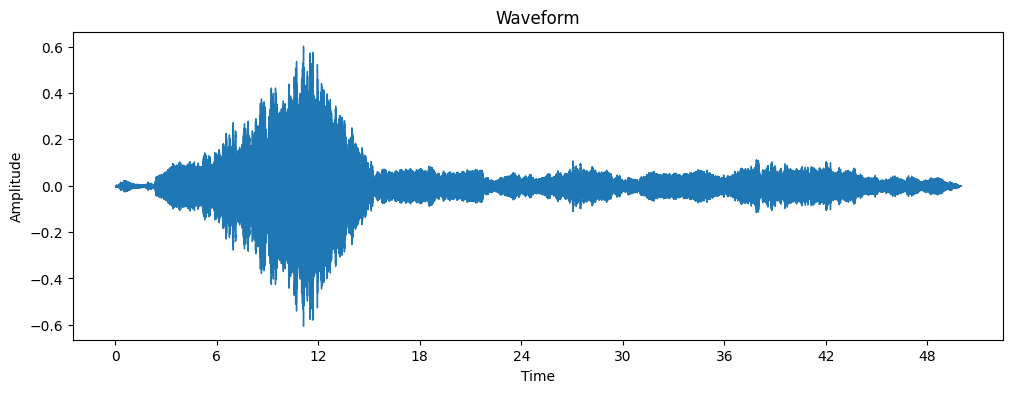

In [8]:
# Plot waveform
plot_waveform(y, sr)

### Sound Display - Spectrogram

#### Spectrogram Explanation
A spectrogram is a *visual representation* of the spectrum of frequencies in a sound or other signal as they vary with time. It's created by applying the **Short-Time Fourier Transform (STFT)** to the audio signal.


Key points about spectrograms:

- X-axis represents time
- Y-axis represents frequency
- Color intensity represents the amplitude of a particular frequency at a particular time
- Useful for analyzing the frequency content of audio over time
- Helps identify patterns, harmonics, and changes in frequency composition

In [9]:
# Function to plot spectrogram
def plot_spectrogram(y, sr, title="Spectrogram"):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max) # <-- STFT
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()


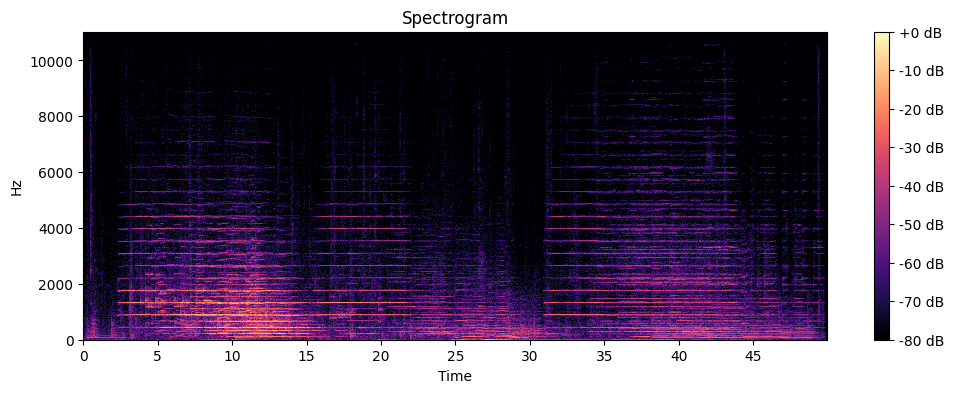

In [10]:
# Plot spectrogram
plot_spectrogram(y, sr)

Before we look at the details of MFCC, let's examine what the Mel-Scale is.

#### Mel Scale

The Mel scale is a perceptual scale of pitches judged by listeners to be equal in distance from one another. It is named after the word "melody" to indicate that it is based on pitch comparisons.

Key characteristics of the Mel scale:

  1. Non-linear relationship with physical frequency:

    * Below 1000 Hz: Almost linear relationship with physical frequency
    * Above 1000 Hz: Logarithmic relationship

  2. Unit: mel
    * 1000 mels is defined as the pitch of a 1000 Hz tone

  3. Conversion formula (approximation):

    ```Copym = 2595 * log10(1 + f/700)```

    Where 'm' is the mel scale value and 'f' is the physical frequency in Hz.

  4. Perceptual basis:
    * Designed to mimic human auditory perception
    * Humans are better at detecting small changes in pitch at low frequencies compared to high frequencies

  5. Applications:
    * Speech recognition
    * Speaker identification
    * Music information retrieval

  6. Advantages:
    * Provides a more perceptually relevant representation of sound
    * Improves performance in various audio processing tasks

The Mel scale is crucial in audio processing because it allows us to represent sound in a way that's more closely aligned with human perception. This often leads to better performance in tasks related to speech and music analysis.

### Sound Display - MFCC

#### MFCC (Mel-Frequency Cepstral Coefficients) Explanation
MFCCs are coefficients that collectively make up an MFC (Mel-frequency cepstrum). They are derived from a type of cepstral representation of the audio clip.

Key points about MFCCs:

1. Computation process:
  * Take the Fourier transform of a signal
  * Map the powers of the spectrum onto the **mel scale**
  * Take the logs of the powers at each of the mel frequencies
  * Take the discrete cosine transform of the list of mel log powers
  * The MFCCs are the amplitudes of the resulting spectrum
2. Characteristics:
  * Compact representation of the spectral envelope
  * Capture the most important parts of the signal for speech recognition
  * Lower-order coefficients represent the overall slope of the spectrum
  * Higher-order coefficients represent fast variations in the spectrum


3. Advantages:
  * Mimic human auditory perception
  * Provide a compact representation of the spectral envelope
  * Decorrelate the features, which is useful for machine learning algorithms

4. Common applications:
  * Speech recognition
  * Speaker identification
  * Music genre classification
  * Audio similarity measures

MFCCs are widely used because they provide a compact and effective representation of audio signals that aligns well with human auditory perception, making them particularly useful for tasks involving speech or music analysis.

In [11]:
# Function to plot MFCC
def plot_mfcc(y, sr, title="MFCC"):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(mfcc, sr=sr, x_axis='time')
    plt.colorbar(format='%+2.0f')
    plt.title(title)
    plt.show()

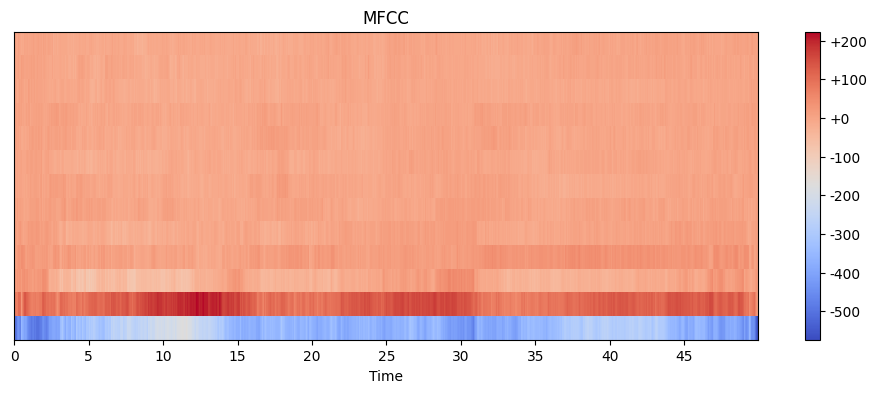

In [12]:
# Plot MFCC
plot_mfcc(y, sr)

### Sound Display - Mel Spectrogram

#### Relationship between Spectrogram and Mel Spectrogram
The Mel spectrogram is a variation of the regular spectrogram that takes into account human auditory perception.

Key differences and relationships:

1. Frequency scale:
  * Regular spectrogram: Linear frequency scale
  * Mel spectrogram: Mel scale (perceptual scale of pitches)

2. Perception alignment:
  * Mel spectrogram better aligns with **human auditory perception**
  * **Emphasizes lower frequencies where human hearing is more sensitive**
3. Computation:
  * Mel spectrogram is created by applying Mel filterbanks to the power spectrogram
4. Use cases:
  * Regular spectrogram: General audio analysis, music processing
  * Mel spectrogram: Speech recognition, genre classification, where human perception is important

In [13]:
# Generate and plot Mel Spectrogram
def plot_mel_spectrogram(y, sr, title="Mel Spectrogram"):
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

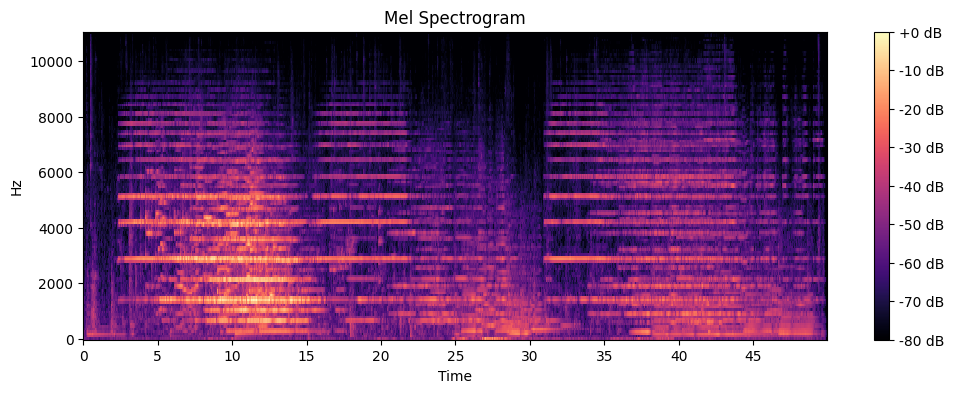

In [14]:
plot_mel_spectrogram(y, sr)

#### Compare Dispaly - Regular-Spectrograms vs Mel-Spectrograms

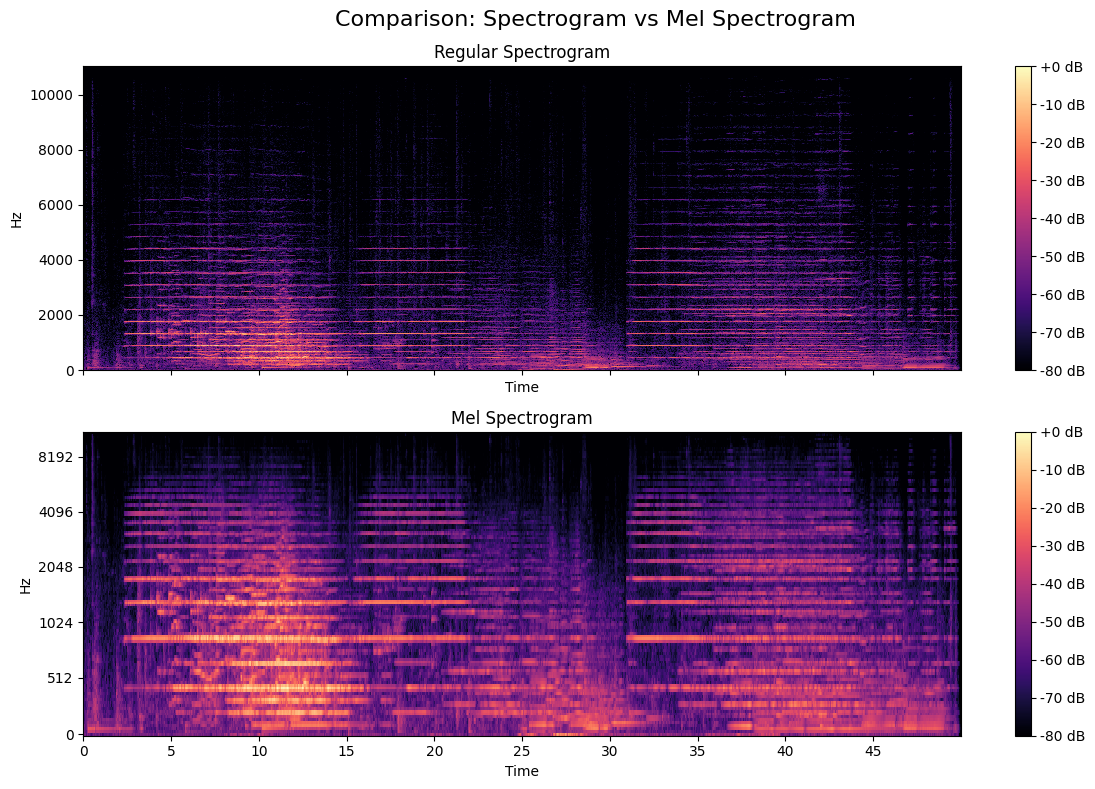

In [15]:
# Function to plot and compare spectrograms
def compare_spectrograms(y, sr):
    # Compute regular spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

    # Compute Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Create subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    fig.suptitle('Comparison: Spectrogram vs Mel Spectrogram', fontsize=16)

    # Plot regular spectrogram
    img1 = librosa.display.specshow(D, x_axis='time', y_axis='hz', ax=axes[0])
    axes[0].set_title('Regular Spectrogram')
    fig.colorbar(img1, ax=axes[0], format='%+2.0f dB')

    # Plot Mel spectrogram
    img2 = librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr, ax=axes[1])
    axes[1].set_title('Mel Spectrogram')
    fig.colorbar(img2, ax=axes[1], format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

# Compare spectrograms
compare_spectrograms(y, sr)

# Conclusion

In this notebook, we've explored various methods of converting sound to image-like representations, using an orchestra tuning sample as our guide. Here are the key takeaways:

1. **Multifaceted Representations**: We've seen how a single sound can be represented in multiple ways - from simple waveforms to complex spectrograms and Mel-frequency based visualizations.
2. **Time-Frequency Trade-offs**: Each method offers a unique balance between time and frequency information. Waveforms excel in temporal precision, while spectrograms and their variants provide rich frequency details.
3. **Perceptual Relevance**: Mel-based methods, particularly Mel spectrograms and MFCCs, demonstrate how we can align our representations with human auditory perception, potentially improving the effectiveness of audio analysis tasks.
4. **Bridge to Machine Learning**: These image-like representations open the door to applying powerful image processing and computer vision techniques, including deep learning models, to audio classification tasks.

By transforming sound into images, we unlock new possibilities for audio analysis, classification, and understanding. This approach bridges the gap between auditory and visual domains, enabling us to leverage the strengths of both in our quest to better process and understand sound.